<a href="https://colab.research.google.com/github/tcapelle/python_ines/blob/master/California_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [117]:
 !curl https://course-v3.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   665  100   665    0     0   3843      0 --:--:-- --:--:-- --:--:--  3866
Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (1.0.37)
Already up to date.


# DL model in GPU

In [0]:
from fastai import *          # Quick accesss to most common functionality
from fastai.tabular import *  # Quick accesss to tabular functionality

In [0]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

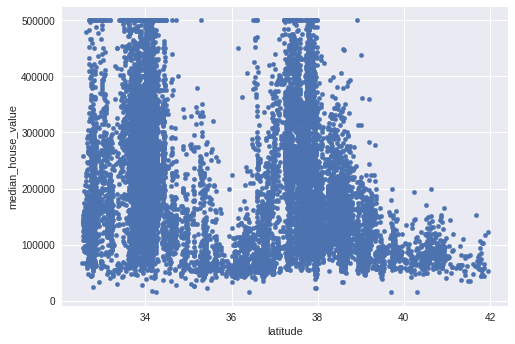

In [120]:
california_housing_dataframe.plot.scatter(x='latitude', y='median_house_value')

In [0]:
california_housing_dataframe['latitude2']=pd.cut(california_housing_dataframe.latitude, bins=[30,33,35,37,39,41,43])

In [0]:
dep_var = 'median_house_value'
cat_names = ['latitude2']
cont_names = ['latitude','longitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']


In [0]:
procs = [FillMissing, Categorify, Normalize]

In [124]:
#random split of train/valid dataframe
np.random.seed(9001)
idx = np.random.permutation(range(17000))[:2000]
idx.sort()
idx

array([    1,     5,    13,    18, ..., 16964, 16972, 16980, 16981])

In [0]:
data = (TabularList.from_df(california_housing_dataframe, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(idx)
                           .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                           .databunch())

In [126]:
data.show_batch(rows=10)

latitude2,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,target
"(33, 35]",-0.7547,0.5696,1.0644,-0.4854,-0.4059,-0.4210,-0.3638,-0.4119,12.723078727722168
"(33, 35]",-0.3527,1.2780,-1.0019,1.9775,1.8238,1.9097,1.6648,-0.1433,11.375959396362305
"(37, 39]",1.4146,-0.5979,-0.9224,-0.1465,-0.2586,-0.2656,-0.3372,-0.1739,11.95697021484375
"(37, 39]",1.0312,-1.3512,1.7797,0.0153,0.0893,-0.1478,0.0982,-0.6061,11.605504989624023
"(35, 37]",0.6058,-1.0968,0.5876,-0.2507,-0.3093,0.0273,-0.2788,-0.3474,12.381285667419434
"(33, 35]",-0.9324,0.9188,-1.0814,-0.5939,-0.6813,-0.9336,-0.7886,-1.0433,11.998433113098145
"(33, 35]",-0.6612,0.1555,-1.3198,5.8763,4.5440,5.0978,4.6519,0.9449,12.61751937866211
"(37, 39]",1.0826,-1.3961,0.9850,-0.0193,0.1159,0.1916,-0.0983,-1.0844,11.286025047302246
"(33, 35]",-0.6659,0.5197,0.6671,-0.3915,-0.4615,-0.3049,-0.3850,0.5418,12.241439819335938
"(30, 33]",-1.3719,1.2431,0.0313,-0.5626,-0.5895,-0.2969,-0.4833,-0.2214,11.67844009399414


In [0]:
max_log_y = np.log(np.max(california_housing_dataframe[dep_var])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [129]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(7, 5)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [130]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,exp_rmspe
1,17.894154,10.633173,0.953837
2,0.468631,0.134356,0.409990
3,0.139571,0.102223,0.387436
4,0.125074,0.143218,0.430848
5,0.104859,0.097144,0.305121
6,0.103754,0.081243,0.300983
7,0.087394,0.071499,0.299152
8,0.084968,0.071062,0.301523
9,0.078708,0.066667,0.283367
10,0.078647,0.064030,0.271151


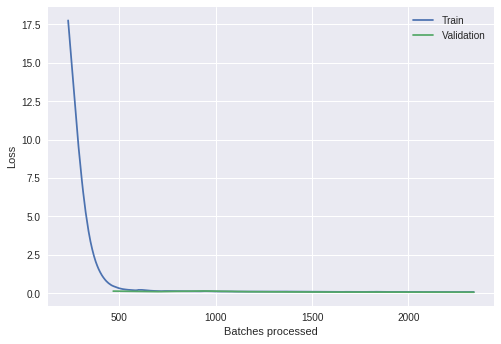

In [131]:
learn.recorder.plot_losses(last=-1)

# DL for bifacial

In [0]:
# DL for bifacial

In [138]:
data

TabularDataBunch;

Train: LabelList
y: FloatList (15000 items)
[FloatItem 11.110954, FloatItem 11.358608, FloatItem 11.203679, FloatItem 11.089806, FloatItem 11.319341]...
Path: .
x: TabularList (15000 items)
[TabularLine latitude2 (33, 35]; latitude -0.6706; longitude 2.6201; housing_median_age -1.0814; total_rooms 1.3931; total_bedrooms 1.8021; population -0.3648; households -0.0717; median_income -1.2573; , TabularLine latitude2 (33, 35]; latitude -0.9044; longitude 2.4953; housing_median_age -0.9224; total_rooms -0.8941; total_bedrooms -0.8770; population -0.9738; households -1.0143; median_income -1.1745; , TabularLine latitude2 (33, 35]; latitude -0.9277; longitude 2.4904; housing_median_age -1.1608; total_rooms -0.5289; total_bedrooms -0.4833; population -0.8113; households -0.7249; median_income -0.3631; , TabularLine latitude2 (33, 35]; latitude -0.9605; longitude 2.4904; housing_median_age -0.6840; total_rooms -0.5509; total_bedrooms -0.5098; population -0.7139; households -0

In [134]:
data.loss_func

In [135]:
learn.loss_func

# MNIST CNN

In [0]:
%matplotlib inline
from fastai import *
from fastai.vision import *

In [0]:
path = untar_data(URLs.MNIST)

In [141]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/testing'),
 PosixPath('/root/.fastai/data/mnist_png/training')]

In [0]:
il = ImageItemList.from_folder(path, convert_mode='L')

In [143]:
il.items[0]

PosixPath('/root/.fastai/data/mnist_png/testing/5/2805.png')

In [0]:
defaults.cmap='binary'

In [145]:
il

ImageItemList (70000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /root/.fastai/data/mnist_png

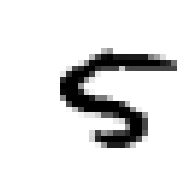

In [146]:
il[0].show()

In [0]:
sd = il.split_by_folder(train='training', valid='testing')

In [148]:
sd

ItemLists;

Train: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /root/.fastai/data/mnist_png;

Valid: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /root/.fastai/data/mnist_png;

Test: None

In [149]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/4')]

In [0]:
ll = sd.label_from_folder()

In [151]:
ll

LabelLists;

Train: LabelList
y: CategoryList (60000 items)
[Category 5, Category 5, Category 5, Category 5, Category 5]...
Path: /root/.fastai/data/mnist_png
x: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /root/.fastai/data/mnist_png;

Valid: LabelList
y: CategoryList (10000 items)
[Category 5, Category 5, Category 5, Category 5, Category 5]...
Path: /root/.fastai/data/mnist_png
x: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
x,y = ll.train[0]

5 torch.Size([1, 28, 28])


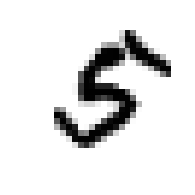

In [153]:
x.show()
print(y,x.shape)

In [0]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [0]:
ll = ll.transform(tfms)

In [0]:
bs = 128

In [0]:
data = ll.databunch(bs=bs).normalize()

In [0]:
x,y = data.train_ds[0]

5


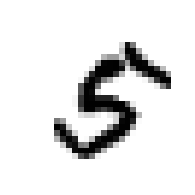

In [159]:
x.show()
print(y)

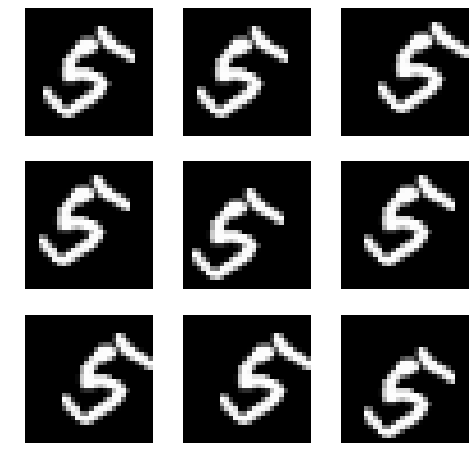

In [160]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [161]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

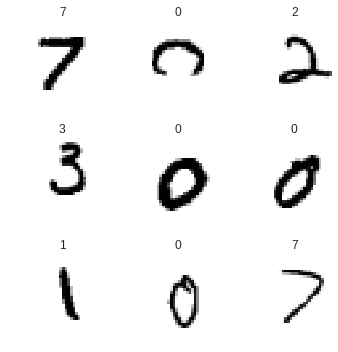

In [162]:
data.show_batch(rows=3, figsize=(5,5))

## Basic CNN

In [0]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [0]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [170]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 14, 14]     80         True      
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
Conv2d               [128, 16, 7, 7]      1168       True      
______________________________________________________________________
BatchNorm2d          [128, 16, 7, 7]      32         True      
______________________________________________________________________
ReLU                 [128, 16, 7, 7]      0          False     
______________________________________________________________________
Conv2d               [128, 32, 4, 4]      4640       True      
______________________________________________________________

In [0]:
xb = xb.cuda()

In [172]:
model(xb).shape

torch.Size([128, 10])

In [173]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


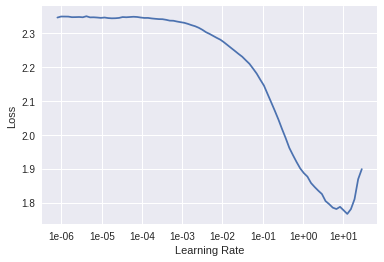

In [174]:
learn.recorder.plot()

In [181]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy


KeyboardInterrupt: ignored

## Refactor

In [0]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [0]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [179]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.243829,0.233551,0.926500
2,0.184597,0.257203,0.921800
3,0.171042,0.096498,0.971300
4,0.134964,0.158030,0.948700
5,0.115884,0.095521,0.973000
6,0.102701,0.084659,0.972300
7,0.086983,0.055057,0.983400
8,0.065979,0.042126,0.987300
9,0.046099,0.030065,0.991000
10,0.049082,0.029094,0.991200


## Resnet-ish

In [0]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [0]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [0]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [0]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


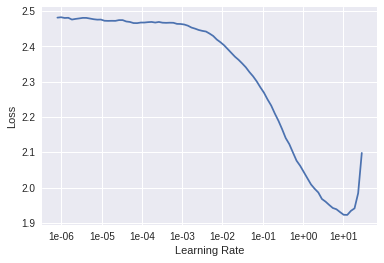

In [186]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy
1,0.254713,0.228992,0.935400
2,0.131283,0.134292,0.959200
3,0.100064,0.274489,0.920000


In [0]:
learn.summary()